# 04 - Exploratory Data Analysis (EDA)

This notebook contains comprehensive EDA for the NASA web server logs:

1. **Time Series Plots** - Traffic over time
2. **Hourly & Daily Patterns** - Seasonality analysis
3. **Distribution Analysis** - Request counts and bytes
4. **Correlation Analysis** - Feature relationships
5. **Anomaly Visualization** - Spike detection
6. **Seasonality Decomposition** - Trend, seasonal, residual

In [26]:
# Standard imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#2ECC71',
    'danger': '#E74C3C',
    'warning': '#F1C40F',
}

print(f"Project root: {project_root}")

Project root: c:\Users\Admin\OneDrive\Documents\python\datafollow


## 1. Load Data

In [27]:
# Paths
DATA_DIR = project_root / "DATA"
PROCESSED_DIR = DATA_DIR / "processed"

# Load feature-engineered 5-minute data
df = pd.read_parquet(PROCESSED_DIR / "train_features_5m.parquet")
df_test = pd.read_parquet(PROCESSED_DIR / "test_features_5m.parquet")

# Also load raw cleaned data for some analyses
df_raw = pd.read_parquet(PROCESSED_DIR / "cleaned_train.parquet")

print(f"Train shape: {df.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nColumns ({len(df.columns)}): {list(df.columns)[:20]}...")

Train shape: (15264, 91)
Test shape: (2592, 91)
Date range: 1995-07-01 00:00:00 to 1995-08-22 23:55:00

Columns (91): ['timestamp', 'request_count', 'unique_hosts', 'error_count', 'error_rate', 'success_rate', 'bytes_total', 'bytes_avg', 'bytes_max', 'requests_per_host', 'bytes_per_request', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend']...


In [28]:
# Quick stats
print("=== REQUEST COUNT STATISTICS ===")
print(df['request_count'].describe())
print(f"\nTotal requests: {df['request_count'].sum():,}")
print(f"Average requests per 5min: {df['request_count'].mean():.1f}")
print(f"Peak requests per 5min: {df['request_count'].max():,}")

=== REQUEST COUNT STATISTICS ===
count    15264.000000
mean       191.913522
std        142.628118
min          0.000000
25%         94.000000
50%        164.000000
75%        272.000000
max       1500.000000
Name: request_count, dtype: float64

Total requests: 2,929,368
Average requests per 5min: 191.9
Peak requests per 5min: 1,500


## 2. Time Series Plots

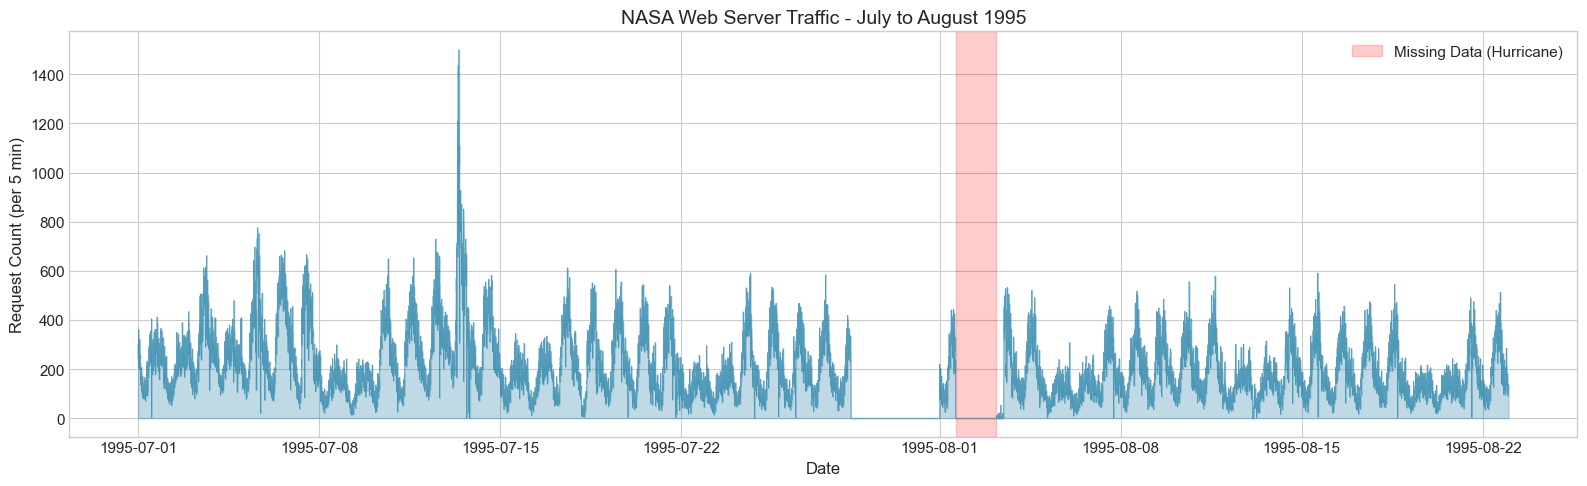

In [29]:
# Overall traffic over time
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(df['timestamp'], df['request_count'], linewidth=0.5, alpha=0.7, color=COLORS['primary'])
ax.fill_between(df['timestamp'], df['request_count'], alpha=0.3, color=COLORS['primary'])

ax.set_xlabel('Date')
ax.set_ylabel('Request Count (per 5 min)')
ax.set_title('NASA Web Server Traffic - July to August 1995')

# Mark missing data period (Aug 1-3)
missing_start = pd.Timestamp('1995-08-01 14:52')
missing_end = pd.Timestamp('1995-08-03 04:36')
ax.axvspan(missing_start, missing_end, color='red', alpha=0.2, label='Missing Data (Hurricane)')

ax.legend()
plt.tight_layout()
plt.show()

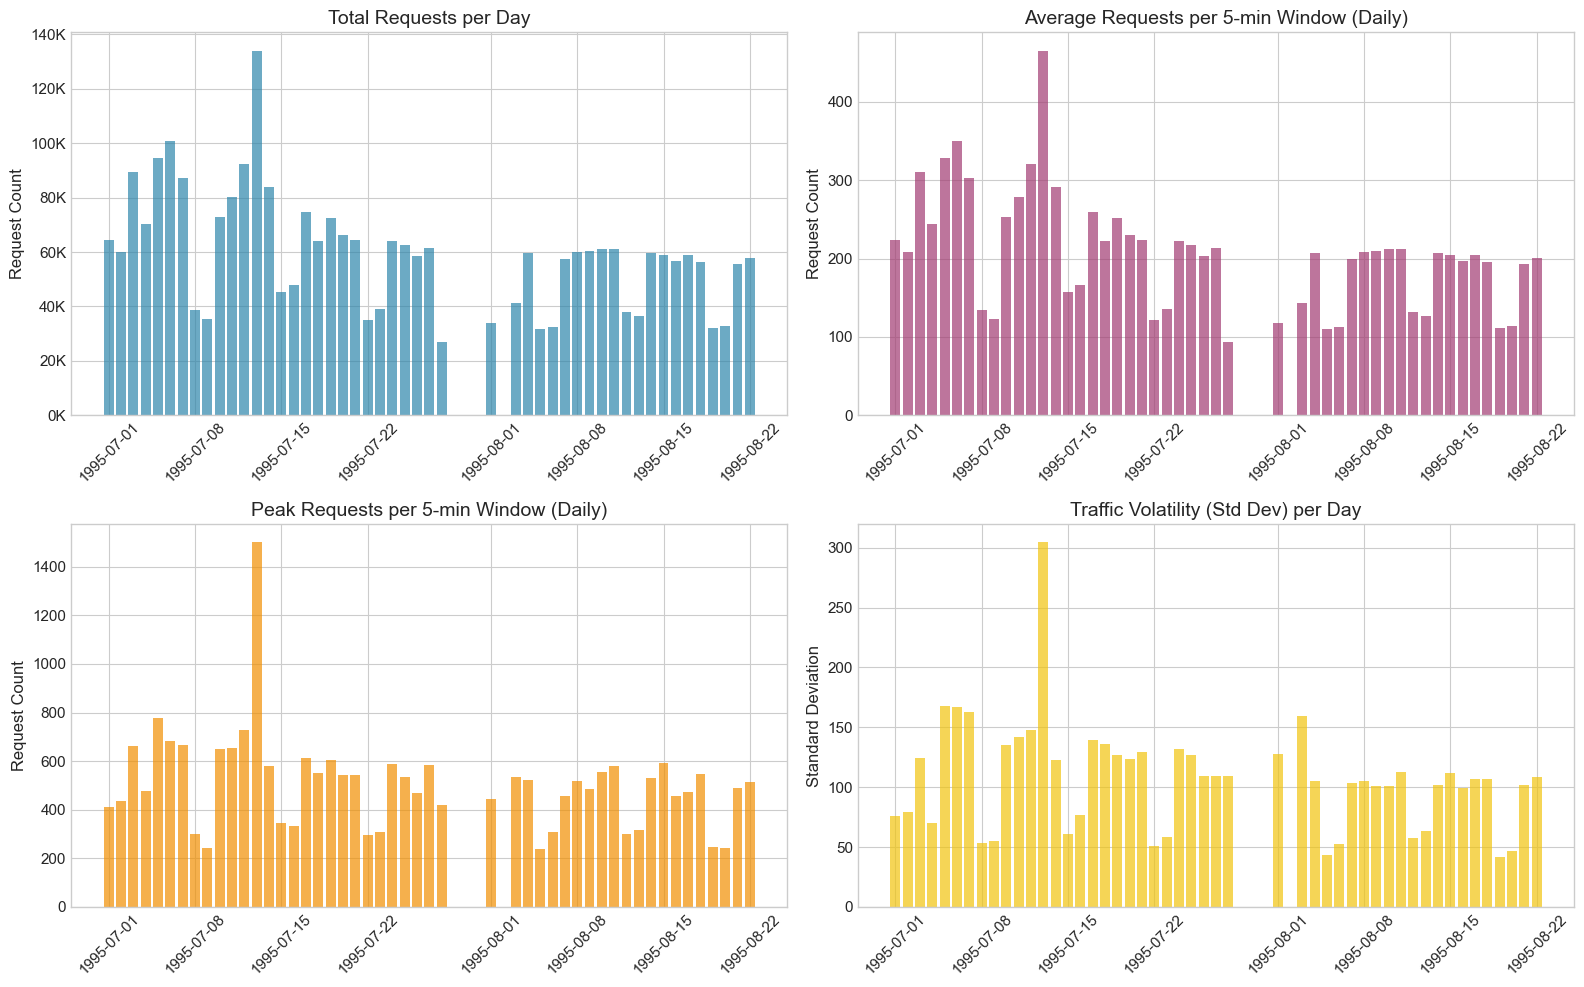

In [30]:
# Daily aggregation
df_daily = df.set_index('timestamp').resample('D')['request_count'].agg(['sum', 'mean', 'max', 'std']).reset_index()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Total requests per day
ax = axes[0, 0]
bars = ax.bar(df_daily['timestamp'], df_daily['sum'], color=COLORS['primary'], alpha=0.7)
ax.set_title('Total Requests per Day')
ax.set_ylabel('Request Count')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))

# Mean requests per 5-min window each day
ax = axes[0, 1]
ax.bar(df_daily['timestamp'], df_daily['mean'], color=COLORS['secondary'], alpha=0.7)
ax.set_title('Average Requests per 5-min Window (Daily)')
ax.set_ylabel('Request Count')

# Peak requests per day
ax = axes[1, 0]
ax.bar(df_daily['timestamp'], df_daily['max'], color=COLORS['accent'], alpha=0.7)
ax.set_title('Peak Requests per 5-min Window (Daily)')
ax.set_ylabel('Request Count')

# Volatility (std) per day
ax = axes[1, 1]
ax.bar(df_daily['timestamp'], df_daily['std'], color=COLORS['warning'], alpha=0.7)
ax.set_title('Traffic Volatility (Std Dev) per Day')
ax.set_ylabel('Standard Deviation')

for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

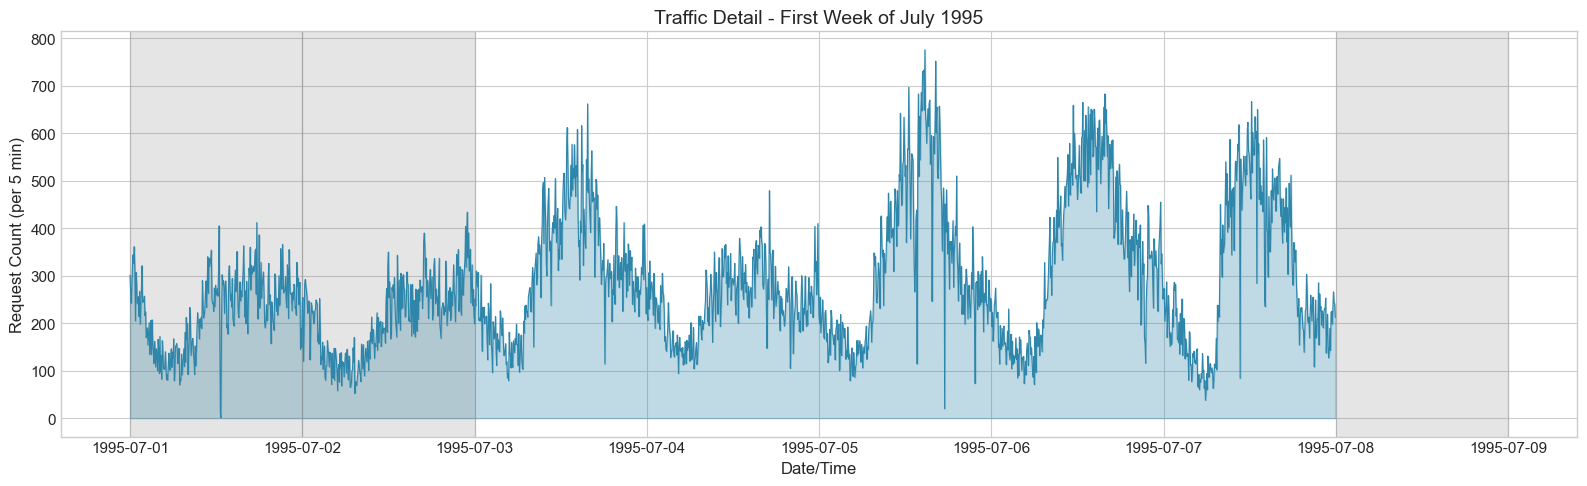

In [31]:
# First week detail view
first_week = df[df['timestamp'] < df['timestamp'].min() + pd.Timedelta(days=7)]

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(first_week['timestamp'], first_week['request_count'], linewidth=0.8, color=COLORS['primary'])
ax.fill_between(first_week['timestamp'], first_week['request_count'], alpha=0.3, color=COLORS['primary'])

ax.set_xlabel('Date/Time')
ax.set_ylabel('Request Count (per 5 min)')
ax.set_title('Traffic Detail - First Week of July 1995')

# Mark weekends
for date in pd.date_range(start='1995-07-01', end='1995-07-08', freq='D'):
    if date.dayofweek >= 5:  # Saturday or Sunday
        ax.axvspan(date, date + pd.Timedelta(days=1), color='gray', alpha=0.2)

plt.tight_layout()
plt.show()

## 3. Hourly & Weekly Patterns

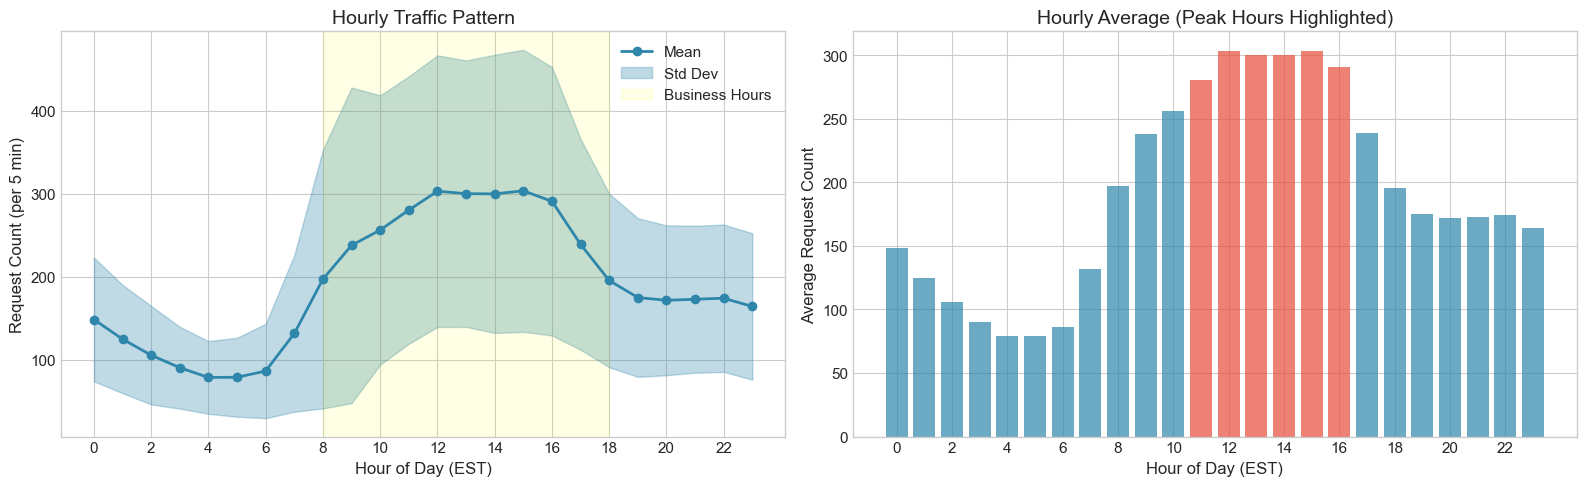


Top 5 Peak Hours:
hour
15    303.463836
12    303.018868
13    300.009434
14    299.784591
16    290.880503
Name: mean, dtype: float64


In [32]:
# Hourly pattern (average by hour of day)
hourly_pattern = df.groupby('hour')['request_count'].agg(['mean', 'std', 'median', 'min', 'max'])

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Line plot with confidence interval
ax = axes[0]
ax.plot(hourly_pattern.index, hourly_pattern['mean'], marker='o', linewidth=2, color=COLORS['primary'], label='Mean')
ax.fill_between(hourly_pattern.index, 
                hourly_pattern['mean'] - hourly_pattern['std'],
                hourly_pattern['mean'] + hourly_pattern['std'],
                alpha=0.3, color=COLORS['primary'], label='Std Dev')
ax.set_xlabel('Hour of Day (EST)')
ax.set_ylabel('Request Count (per 5 min)')
ax.set_title('Hourly Traffic Pattern')
ax.set_xticks(range(0, 24, 2))
ax.axvspan(8, 18, color='yellow', alpha=0.1, label='Business Hours')
ax.legend()

# Bar plot
ax = axes[1]
colors = [COLORS['danger'] if h in range(11, 17) else COLORS['primary'] for h in hourly_pattern.index]
ax.bar(hourly_pattern.index, hourly_pattern['mean'], color=colors, alpha=0.7)
ax.set_xlabel('Hour of Day (EST)')
ax.set_ylabel('Average Request Count')
ax.set_title('Hourly Average (Peak Hours Highlighted)')
ax.set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

# Print peak hours
print("\nTop 5 Peak Hours:")
print(hourly_pattern.nlargest(5, 'mean')['mean'])

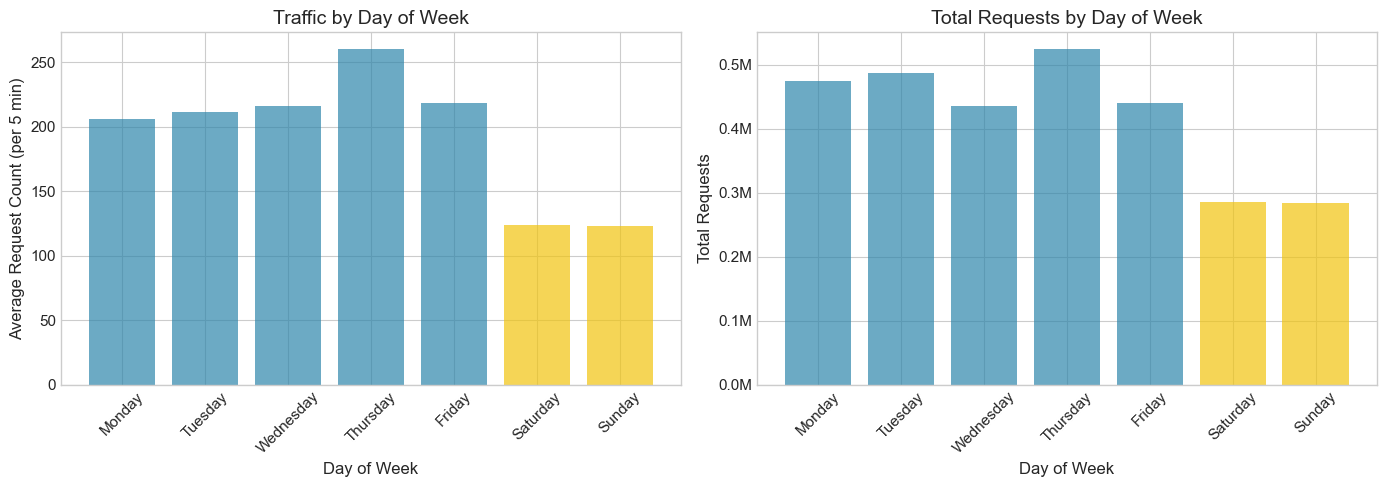


Weekday average: 221.4 requests/5min
Weekend average: 123.6 requests/5min
Weekend drop: 44.2%


In [33]:
# Day of week pattern
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_pattern = df.groupby('day_of_week')['request_count'].agg(['mean', 'std', 'sum'])
dow_pattern['name'] = dow_names

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean by day of week
ax = axes[0]
colors = [COLORS['warning'] if i >= 5 else COLORS['primary'] for i in range(7)]
ax.bar(dow_pattern['name'], dow_pattern['mean'], color=colors, alpha=0.7)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Request Count (per 5 min)')
ax.set_title('Traffic by Day of Week')
ax.tick_params(axis='x', rotation=45)

# Total by day of week
ax = axes[1]
ax.bar(dow_pattern['name'], dow_pattern['sum'], color=colors, alpha=0.7)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Total Requests')
ax.set_title('Total Requests by Day of Week')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Weekend vs Weekday comparison
weekday_avg = df[df['is_weekend'] == 0]['request_count'].mean()
weekend_avg = df[df['is_weekend'] == 1]['request_count'].mean()
print(f"\nWeekday average: {weekday_avg:.1f} requests/5min")
print(f"Weekend average: {weekend_avg:.1f} requests/5min")
print(f"Weekend drop: {(1 - weekend_avg/weekday_avg)*100:.1f}%")

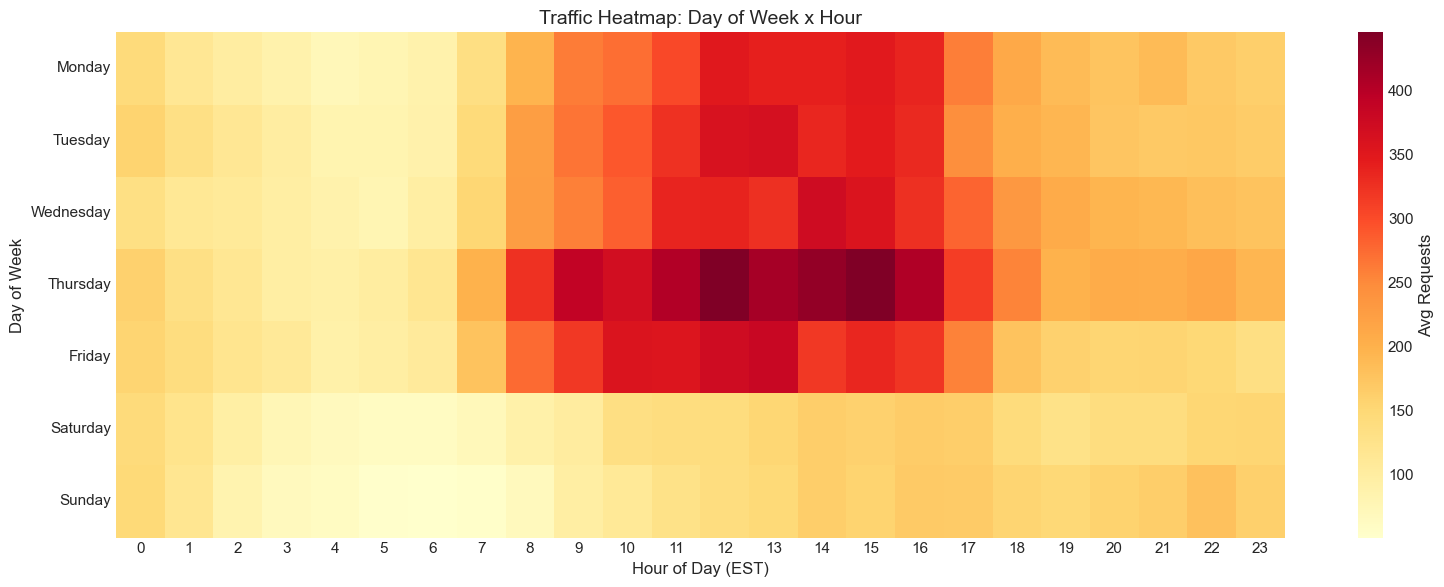

In [34]:
# Heatmap: Hour x Day of Week
pivot = df.groupby(['day_of_week', 'hour'])['request_count'].mean().unstack()
pivot.index = dow_names

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(pivot, cmap='YlOrRd', annot=False, fmt='.0f', ax=ax, cbar_kws={'label': 'Avg Requests'})
ax.set_title('Traffic Heatmap: Day of Week x Hour')
ax.set_xlabel('Hour of Day (EST)')
ax.set_ylabel('Day of Week')

plt.tight_layout()
plt.show()

## 4. Distribution Analysis

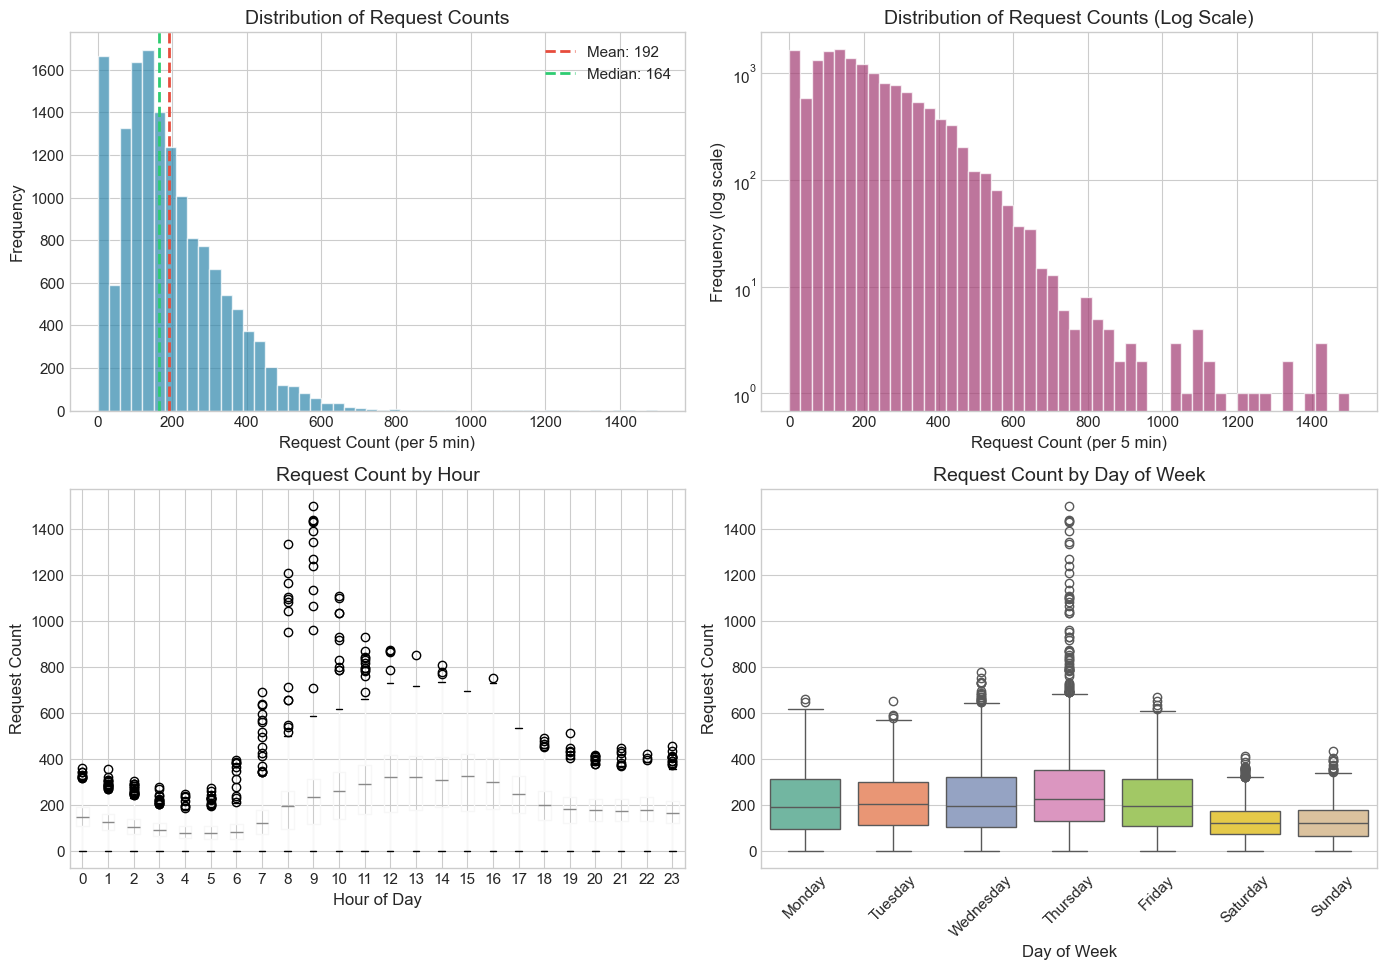

In [35]:
# Request count distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
ax = axes[0, 0]
ax.hist(df['request_count'], bins=50, color=COLORS['primary'], alpha=0.7, edgecolor='white')
ax.axvline(df['request_count'].mean(), color=COLORS['danger'], linestyle='--', linewidth=2, label=f'Mean: {df["request_count"].mean():.0f}')
ax.axvline(df['request_count'].median(), color=COLORS['success'], linestyle='--', linewidth=2, label=f'Median: {df["request_count"].median():.0f}')
ax.set_xlabel('Request Count (per 5 min)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Request Counts')
ax.legend()

# Log-scale histogram
ax = axes[0, 1]
ax.hist(df['request_count'], bins=50, color=COLORS['secondary'], alpha=0.7, edgecolor='white')
ax.set_yscale('log')
ax.set_xlabel('Request Count (per 5 min)')
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Distribution of Request Counts (Log Scale)')

# Box plot by hour
ax = axes[1, 0]
df.boxplot(column='request_count', by='hour', ax=ax)
ax.set_title('Request Count by Hour')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Request Count')
plt.suptitle('')  # Remove automatic title

# Box plot by day of week
ax = axes[1, 1]
df_plot = df.copy()
df_plot['dow_name'] = df_plot['day_of_week'].map(dict(enumerate(dow_names)))
order = dow_names
sns.boxplot(data=df_plot, x='dow_name', y='request_count', order=order, ax=ax, palette='Set2')
ax.set_title('Request Count by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Request Count')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

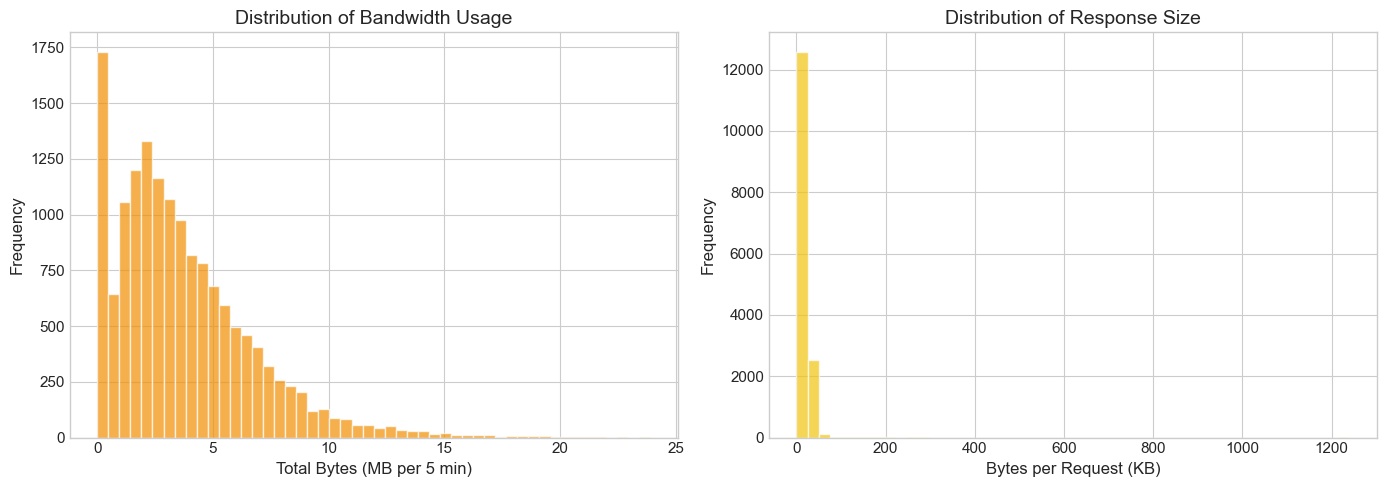


Bandwidth Statistics:
Total bandwidth: 56.86 GB
Avg per 5min: 3.72 MB
Peak per 5min: 23.90 MB


In [36]:
# Bytes distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bytes total per 5-min window
ax = axes[0]
ax.hist(df['bytes_total'] / 1e6, bins=50, color=COLORS['accent'], alpha=0.7, edgecolor='white')
ax.set_xlabel('Total Bytes (MB per 5 min)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Bandwidth Usage')

# Bytes per request
ax = axes[1]
ax.hist(df['bytes_per_request'] / 1024, bins=50, color=COLORS['warning'], alpha=0.7, edgecolor='white')
ax.set_xlabel('Bytes per Request (KB)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Response Size')

plt.tight_layout()
plt.show()

print(f"\nBandwidth Statistics:")
print(f"Total bandwidth: {df['bytes_total'].sum() / 1e9:.2f} GB")
print(f"Avg per 5min: {df['bytes_total'].mean() / 1e6:.2f} MB")
print(f"Peak per 5min: {df['bytes_total'].max() / 1e6:.2f} MB")

## 5. Correlation Analysis

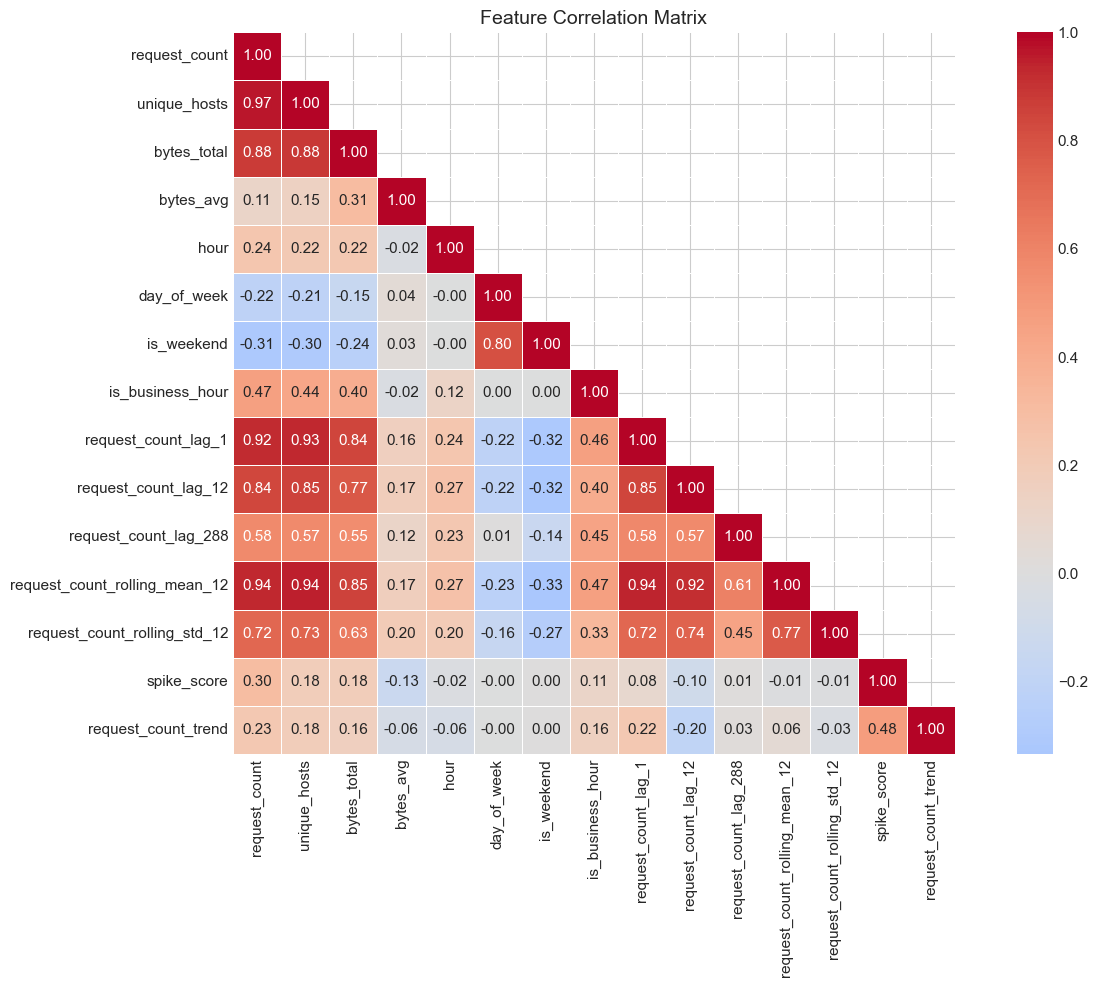

In [37]:
# Select key features for correlation
key_features = [
    'request_count', 'unique_hosts', 'bytes_total', 'bytes_avg',
    'hour', 'day_of_week', 'is_weekend', 'is_business_hour',
    'request_count_lag_1', 'request_count_lag_12', 'request_count_lag_288',
    'request_count_rolling_mean_12', 'request_count_rolling_std_12',
    'spike_score', 'request_count_trend'
]

# Filter to existing columns
key_features = [f for f in key_features if f in df.columns]

# Correlation matrix
corr_matrix = df[key_features].corr()

fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax,
            square=True, linewidths=0.5)
ax.set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

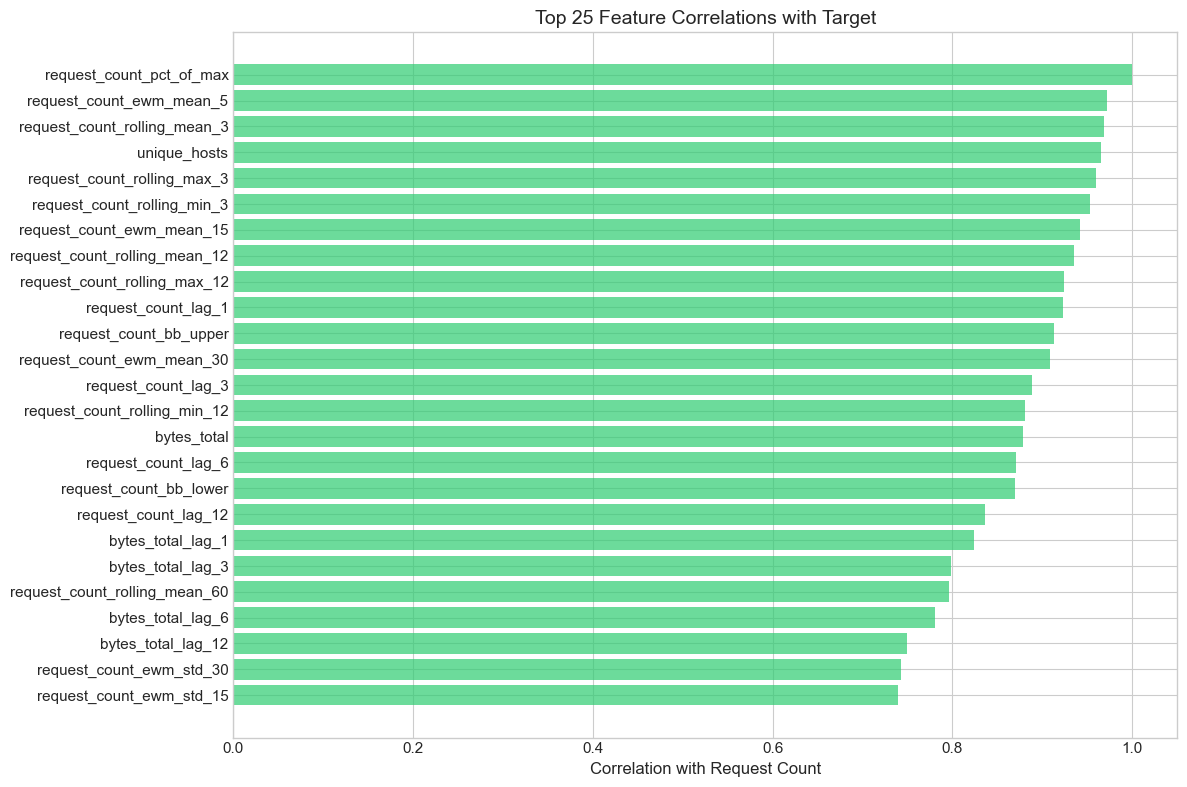

In [38]:
# Top correlations with target
target = 'request_count'
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target]

correlations = df[numeric_cols + [target]].corr()[target].drop(target).sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
top_corr = correlations.head(25)
colors = [COLORS['success'] if v > 0 else COLORS['danger'] for v in top_corr.values]
ax.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_corr)))
ax.set_yticklabels(top_corr.index)
ax.set_xlabel('Correlation with Request Count')
ax.set_title('Top 25 Feature Correlations with Target')
ax.axvline(0, color='black', linewidth=0.5)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## 6. Anomaly & Spike Detection

Total spikes detected: 10
Total dips detected: 6


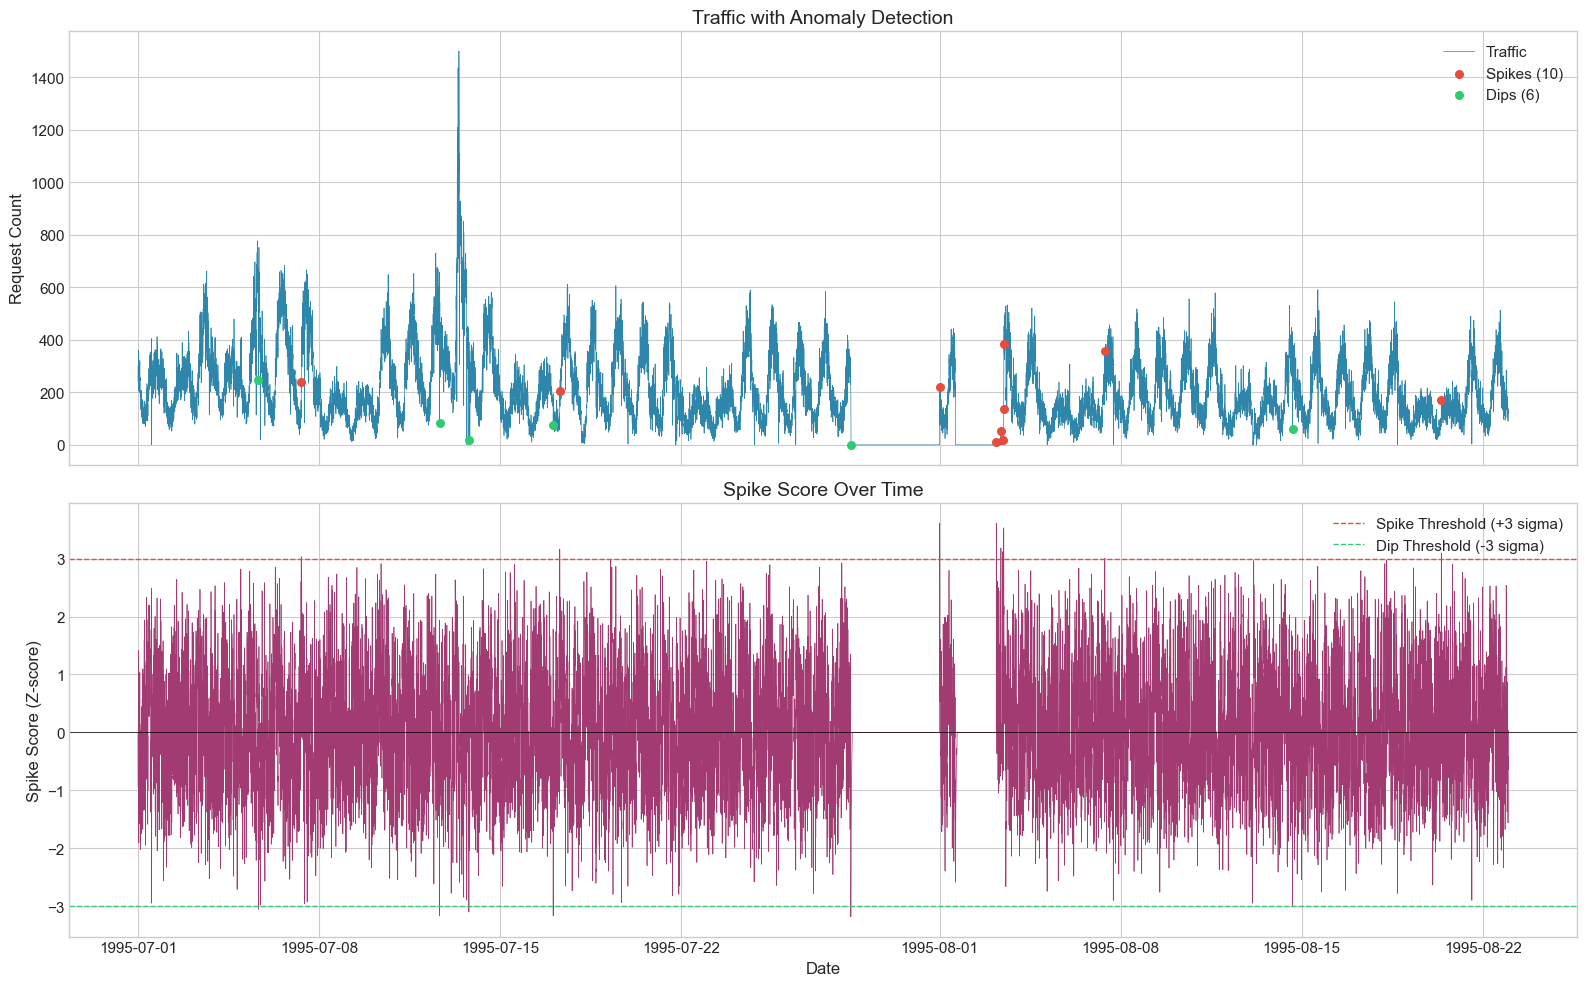

In [39]:
# Spike detection visualization
spikes = df[df['is_spike'] == 1]
dips = df[df['is_dip'] == 1] if 'is_dip' in df.columns else pd.DataFrame()

print(f"Total spikes detected: {len(spikes)}")
print(f"Total dips detected: {len(dips)}")

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Traffic with spikes
ax = axes[0]
ax.plot(df['timestamp'], df['request_count'], linewidth=0.5, color=COLORS['primary'], label='Traffic')
ax.scatter(spikes['timestamp'], spikes['request_count'], color=COLORS['danger'], s=30, zorder=5, label=f'Spikes ({len(spikes)})')
if len(dips) > 0:
    ax.scatter(dips['timestamp'], dips['request_count'], color=COLORS['success'], s=30, zorder=5, label=f'Dips ({len(dips)})')
ax.set_ylabel('Request Count')
ax.set_title('Traffic with Anomaly Detection')
ax.legend()

# Spike score
ax = axes[1]
ax.plot(df['timestamp'], df['spike_score'], linewidth=0.5, color=COLORS['secondary'])
ax.axhline(y=3, color=COLORS['danger'], linestyle='--', linewidth=1, label='Spike Threshold (+3 sigma)')
ax.axhline(y=-3, color=COLORS['success'], linestyle='--', linewidth=1, label='Dip Threshold (-3 sigma)')
ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Spike Score (Z-score)')
ax.set_title('Spike Score Over Time')
ax.legend()

plt.tight_layout()
plt.show()

In [40]:
# Top spikes analysis
print("\n=== TOP 10 TRAFFIC SPIKES ===")
top_spikes = spikes.nlargest(10, 'spike_score')[['timestamp', 'request_count', 'spike_score', 'unique_hosts']]
print(top_spikes.to_string())

# Check if July 13 appears (known spike from analysis)
jul13_data = df[df['timestamp'].dt.date == pd.Timestamp('1995-07-13').date()]
print(f"\n=== JULY 13, 1995 ANALYSIS ===")
print(f"Max request count: {jul13_data['request_count'].max()}")
print(f"Time of peak: {jul13_data.loc[jul13_data['request_count'].idxmax(), 'timestamp']}")


=== TOP 10 TRAFFIC SPIKES ===
                timestamp  request_count  spike_score  unique_hosts
8928  1995-08-01 00:00:00            220     3.614784            29
9559  1995-08-03 04:35:00             10     3.614784             1
9641  1995-08-03 11:25:00            135     3.531434            27
9642  1995-08-03 11:30:00            386     3.405585            55
9610  1995-08-03 08:50:00             53     3.184271             7
4697  1995-07-17 07:25:00            207     3.162328            37
9630  1995-08-03 10:30:00             18     3.120197             4
14515 1995-08-20 09:35:00            169     3.098340            29
1818  1995-07-07 07:30:00            238     3.031809            42
10767 1995-08-07 09:15:00            358     3.006903            49

=== JULY 13, 1995 ANALYSIS ===
Max request count: 1500
Time of peak: 1995-07-13 09:50:00


### 6.1 ML-Based Anomaly Detection Comparison (NEW!)

In [41]:
# Enhanced Anomaly Detection Comparison (Day 2 Update)
if 'is_anomaly_ml' in df.columns:
    fig, axes = plt.subplots(3, 1, figsize=(18, 14), sharex=True)
    
    # Use full data for better overview
    plot_df = df.copy()
    
    # 1. Statistical Anomaly Detection (Z-score)
    ax1 = axes[0]
    ax1.plot(plot_df['timestamp'], plot_df['request_count'], linewidth=0.5, alpha=0.6, color=COLORS['primary'])
    ax1.fill_between(plot_df['timestamp'], plot_df['request_count'], alpha=0.2, color=COLORS['primary'])
    if 'is_spike' in plot_df.columns:
        z_anomalies = plot_df[plot_df['is_spike'] == 1]
        ax1.scatter(z_anomalies['timestamp'], z_anomalies['request_count'], 
                   color=COLORS['danger'], s=60, label=f'Z-score Anomalies ({len(z_anomalies)})', 
                   zorder=5, alpha=0.9, edgecolor='black', linewidth=0.5)
    ax1.set_ylabel('Request Count', fontsize=12)
    ax1.set_title('Statistical Anomaly Detection (3-Sigma Z-score)', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 2. ML-based Anomaly Detection (IsolationForest)
    ax2 = axes[1]
    ax2.plot(plot_df['timestamp'], plot_df['request_count'], linewidth=0.5, alpha=0.6, color=COLORS['primary'])
    ax2.fill_between(plot_df['timestamp'], plot_df['request_count'], alpha=0.2, color=COLORS['primary'])
    ml_anomalies = plot_df[plot_df['is_anomaly_ml'] == 1]
    ax2.scatter(ml_anomalies['timestamp'], ml_anomalies['request_count'],
               color=COLORS['accent'], s=60, label=f'IsolationForest Anomalies ({len(ml_anomalies)})', 
               zorder=5, alpha=0.9, edgecolor='black', linewidth=0.5)
    ax2.set_ylabel('Request Count', fontsize=12)
    ax2.set_title('ML-based Anomaly Detection (Isolation Forest, contamination=1%)', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # 3. Combined View with Agreement Highlighting
    ax3 = axes[2]
    ax3.plot(plot_df['timestamp'], plot_df['request_count'], linewidth=0.5, alpha=0.5, 
             color=COLORS['primary'], label='Normal Traffic')
    
    # Only Z-score (not detected by ML)
    if 'is_spike' in plot_df.columns:
        only_z = plot_df[(plot_df['is_spike'] == 1) & (plot_df['is_anomaly_ml'] == 0)]
        ax3.scatter(only_z['timestamp'], only_z['request_count'],
                   color=COLORS['danger'], s=50, label=f'Only Z-score ({len(only_z)})', 
                   alpha=0.7, marker='o', edgecolor='darkred', linewidth=0.5)
    
    # Only ML (not detected by Z-score)
    only_ml = plot_df[(plot_df['is_anomaly_ml'] == 1) & (plot_df.get('is_spike', 0) == 0)]
    ax3.scatter(only_ml['timestamp'], only_ml['request_count'],
               color=COLORS['accent'], s=50, label=f'Only ML ({len(only_ml)})', 
               alpha=0.7, marker='s', edgecolor='darkorange', linewidth=0.5)
    
    # Both methods agree (high confidence anomalies)
    if 'anomaly_agreement' in plot_df.columns:
        both = plot_df[plot_df['anomaly_agreement'] == 1]
        ax3.scatter(both['timestamp'], both['request_count'],
                   color=COLORS['secondary'], s=150, label=f'BOTH AGREE ({len(both)})', 
                   zorder=10, marker='*', edgecolor='black', linewidth=1)
    
    ax3.set_ylabel('Request Count', fontsize=12)
    ax3.set_xlabel('Date', fontsize=12)
    ax3.set_title('Combined Anomaly Detection: Method Agreement Analysis', fontsize=13, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Add Hurricane period annotation
    ax3.axvspan(pd.Timestamp('1995-08-01'), pd.Timestamp('1995-08-03'), 
                color='gray', alpha=0.3, label='Hurricane Period')
    
    plt.tight_layout()
    plt.savefig(project_root / 'reports' / 'figures' / 'anomaly_detection_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print comparison statistics
    print("\n" + "="*70)
    print("ANOMALY DETECTION COMPARISON SUMMARY")
    print("="*70)
    if 'is_spike' in df.columns:
        print(f"Z-score method:      {df['is_spike'].sum():>5} anomalies ({df['is_spike'].mean()*100:.3f}%)")
    print(f"IsolationForest:     {df['is_anomaly_ml'].sum():>5} anomalies ({df['is_anomaly_ml'].mean()*100:.3f}%)")
    if 'anomaly_agreement' in df.columns:
        print(f"Both methods agree:  {df['anomaly_agreement'].sum():>5} cases (HIGH CONFIDENCE)")
        if df['is_spike'].sum() > 0:
            print(f"Agreement rate:      {df['anomaly_agreement'].sum() / df['is_spike'].sum() * 100:.1f}% of Z-score anomalies")
    print("="*70)
    print("\n✓ Anomaly comparison plot saved to reports/figures/anomaly_detection_comparison.png")
else:
    print("⚠️ ML anomaly detection not available. Run notebook 03 first.")

⚠️ ML anomaly detection not available. Run notebook 03 first.


### 6.2 Special Events Analysis (NEW!)

In [42]:
# Enhanced Special Events Analysis (Day 2 Update)
if 'is_special_event' in df.columns and df['is_special_event'].sum() > 0:
    
    events_df = df[df['is_special_event'] == 1]
    
    print("="*70)
    print("SPECIAL EVENTS ANALYSIS")
    print("="*70)
    
    # Event summary table
    event_summary = events_df.groupby(['event_name', 'event_type', 'event_impact'])['request_count'].agg([
        ('avg_traffic', 'mean'),
        ('max_traffic', 'max'),
        ('min_traffic', 'min'),
        ('periods', 'count')
    ]).reset_index().sort_values('avg_traffic', ascending=False)
    
    print("\n--- Events by Average Traffic ---")
    print(event_summary.to_string(index=False))
    
    # Traffic comparison
    normal_avg = df[df['is_special_event'] == 0]['request_count'].mean()
    event_avg = events_df['request_count'].mean()
    
    print(f"\n--- Traffic Comparison ---")
    print(f"Normal days average:  {normal_avg:.1f} requests/5min")
    print(f"Event days average:   {event_avg:.1f} requests/5min")
    print(f"Impact:               {(event_avg/normal_avg - 1)*100:+.1f}%")
    
    # Visualization: Event Impact Analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Traffic by Event Type
    ax = axes[0, 0]
    event_type_names = {0: 'Normal', 1: 'Holiday', 2: 'Space Event', 3: 'Outage'}
    type_traffic = df.groupby('event_type')['request_count'].mean()
    type_traffic.index = type_traffic.index.map(event_type_names)
    colors = [COLORS['primary'], COLORS['warning'], COLORS['danger'], COLORS['secondary']]
    bars = ax.bar(type_traffic.index, type_traffic.values, color=colors[:len(type_traffic)], alpha=0.8, edgecolor='black')
    ax.axhline(normal_avg, color='gray', linestyle='--', linewidth=2, label=f'Overall Avg: {normal_avg:.0f}')
    ax.set_ylabel('Avg Request Count', fontsize=11)
    ax.set_title('Average Traffic by Event Type', fontsize=13, fontweight='bold')
    ax.legend()
    for bar, val in zip(bars, type_traffic.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{val:.0f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 2. Traffic Distribution: Event vs Normal
    ax = axes[0, 1]
    ax.hist(df[df['is_special_event'] == 0]['request_count'], bins=40, alpha=0.6, 
            label='Normal Days', color=COLORS['primary'], edgecolor='white')
    ax.hist(events_df['request_count'], bins=40, alpha=0.6, 
            label='Event Days', color=COLORS['danger'], edgecolor='white')
    ax.axvline(normal_avg, color=COLORS['primary'], linestyle='--', linewidth=2, label=f'Normal Avg: {normal_avg:.0f}')
    ax.axvline(event_avg, color=COLORS['danger'], linestyle='--', linewidth=2, label=f'Event Avg: {event_avg:.0f}')
    ax.set_xlabel('Request Count', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Traffic Distribution: Normal vs Event Days', fontsize=13, fontweight='bold')
    ax.legend()
    
    # 3. Timeline with Events Highlighted
    ax = axes[1, 0]
    ax.plot(df['timestamp'], df['request_count'], linewidth=0.3, alpha=0.5, color=COLORS['primary'])
    
    # Highlight different event types
    for etype, color, name in [(1, COLORS['warning'], 'Holiday'), 
                                (2, COLORS['danger'], 'Space Event'), 
                                (3, 'gray', 'Outage')]:
        event_periods = df[df['event_type'] == etype]
        if len(event_periods) > 0:
            ax.scatter(event_periods['timestamp'], event_periods['request_count'], 
                      c=color, s=20, alpha=0.7, label=name)
    
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Request Count', fontsize=11)
    ax.set_title('Traffic Timeline with Events Highlighted', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # 4. Event Impact Bar Chart (detailed)
    ax = axes[1, 1]
    event_means = event_summary.head(10).copy()
    if len(event_means) > 0:
        y_pos = range(len(event_means))
        colors_bar = [COLORS['danger'] if 'STS' in str(name) else 
                     COLORS['warning'] if 'Independence' in str(name) else
                     'gray' for name in event_means['event_name']]
        ax.barh(y_pos, event_means['avg_traffic'], color=colors_bar, alpha=0.8, edgecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(event_means['event_name'], fontsize=9)
        ax.axvline(normal_avg, color='black', linestyle='--', linewidth=2, label=f'Normal Avg: {normal_avg:.0f}')
        ax.set_xlabel('Avg Request Count', fontsize=11)
        ax.set_title('Top 10 Events by Traffic', fontsize=13, fontweight='bold')
        ax.legend()
        ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig(project_root / 'reports' / 'figures' / 'event_impact_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("="*70)
    print("\n✓ Event impact analysis saved to reports/figures/event_impact_analysis.png")

else:
    print("⚠️ No special events detected. Run notebook 03 with updated advanced_features.py")

⚠️ No special events detected. Run notebook 03 with updated advanced_features.py


### 6.3 Model Predictions Comparison (Day 2 - NEW!)

In [43]:
# Load trained models and generate predictions for comparison
import joblib
import json

MODELS_DIR = project_root / "models"

# Load feature names
with open(MODELS_DIR / "feature_names.json", 'r') as f:
    feature_cols = json.load(f)

# Load test data
X_test = df_test[feature_cols].fillna(df_test[feature_cols].median())
y_test = df_test['request_count']

# Load LightGBM model
try:
    from src.models.lgbm_model import LGBMModel
    lgbm_model = LGBMModel.load(MODELS_DIR / "lgbm_5m.pkl")
    lgbm_pred = lgbm_model.predict(X_test)
    print(f"✓ LightGBM loaded - Test predictions: {len(lgbm_pred)}")
except Exception as e:
    lgbm_pred = None
    print(f"⚠️ LightGBM not available: {e}")

# Load Prophet model
try:
    from src.models.prophet_model import ProphetModel
    prophet_model = ProphetModel.load(MODELS_DIR / "prophet_5m.pkl")
    prophet_pred = prophet_model.predict(df_test[['timestamp']])['yhat'].values
    print(f"✓ Prophet loaded - Test predictions: {len(prophet_pred)}")
except Exception as e:
    prophet_pred = None
    print(f"⚠️ Prophet not available: {e}")

# Load SARIMA model
try:
    from src.models.sarima import SARIMAModel
    sarima_model = SARIMAModel.load(MODELS_DIR / "sarima_5m.pkl")
    sarima_pred = sarima_model.predict(steps=len(df_test))
    print(f"✓ SARIMA loaded - Test predictions: {len(sarima_pred)}")
except Exception as e:
    sarima_pred = None
    print(f"⚠️ SARIMA not available: {e}")

⚠️ LightGBM not available: No module named 'lightgbm'
⚠️ Prophet not available: No module named 'prophet'
✓ SARIMA loaded - Test predictions: 2592


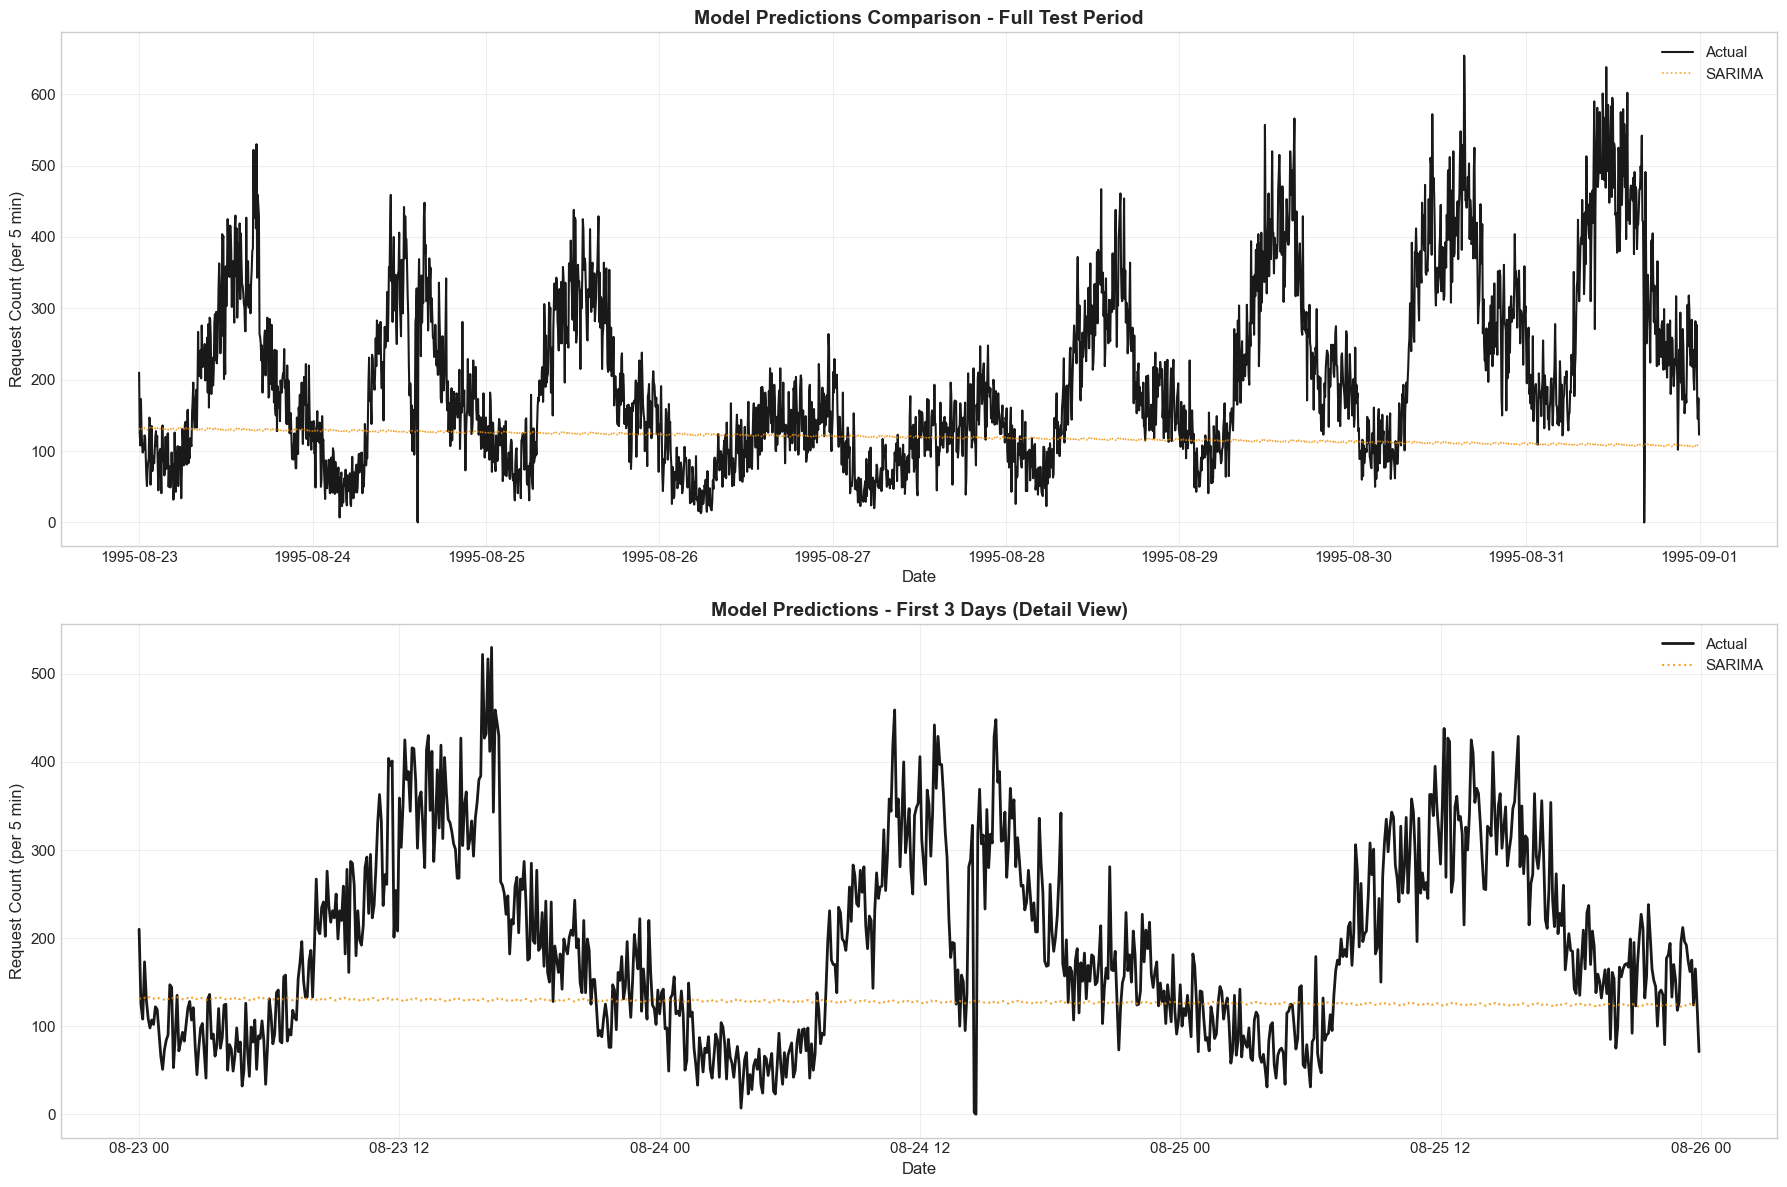


✓ Overlay plot saved to reports/figures/model_comparison_overlay.png


In [44]:
# OVERLAY PLOT: Actual vs All Models
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Full test period
ax = axes[0]
ax.plot(df_test['timestamp'], y_test, label='Actual', color='black', linewidth=1.5, alpha=0.9)

if prophet_pred is not None:
    ax.plot(df_test['timestamp'], prophet_pred, label='Prophet', color=COLORS['secondary'], 
            linewidth=1.2, linestyle='--', alpha=0.8)

if lgbm_pred is not None:
    ax.plot(df_test['timestamp'], lgbm_pred, label='LightGBM', color=COLORS['success'], 
            linewidth=1.2, linestyle='-.', alpha=0.8)

if sarima_pred is not None:
    ax.plot(df_test['timestamp'], sarima_pred, label='SARIMA', color=COLORS['accent'], 
            linewidth=1.2, linestyle=':', alpha=0.8)

ax.set_xlabel('Date')
ax.set_ylabel('Request Count (per 5 min)')
ax.set_title('Model Predictions Comparison - Full Test Period', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

# Zoomed view - First 3 days
ax = axes[1]
n_detail = 288 * 3  # 3 days of 5-min data

ax.plot(df_test['timestamp'].iloc[:n_detail], y_test.iloc[:n_detail], 
        label='Actual', color='black', linewidth=2, alpha=0.9)

if prophet_pred is not None:
    ax.plot(df_test['timestamp'].iloc[:n_detail], prophet_pred[:n_detail], 
            label='Prophet', color=COLORS['secondary'], linewidth=1.5, linestyle='--', alpha=0.8)

if lgbm_pred is not None:
    ax.plot(df_test['timestamp'].iloc[:n_detail], lgbm_pred[:n_detail], 
            label='LightGBM', color=COLORS['success'], linewidth=1.5, linestyle='-.', alpha=0.8)

if sarima_pred is not None:
    ax.plot(df_test['timestamp'].iloc[:n_detail], sarima_pred[:n_detail], 
            label='SARIMA', color=COLORS['accent'], linewidth=1.5, linestyle=':', alpha=0.8)

ax.set_xlabel('Date')
ax.set_ylabel('Request Count (per 5 min)')
ax.set_title('Model Predictions - First 3 Days (Detail View)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'reports' / 'figures' / 'model_comparison_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Overlay plot saved to reports/figures/model_comparison_overlay.png")

MODEL PERFORMANCE COMPARISON (Test Set)
SARIMA:    RMSE=150.37  MAE=108.56  MAPE=58.5%


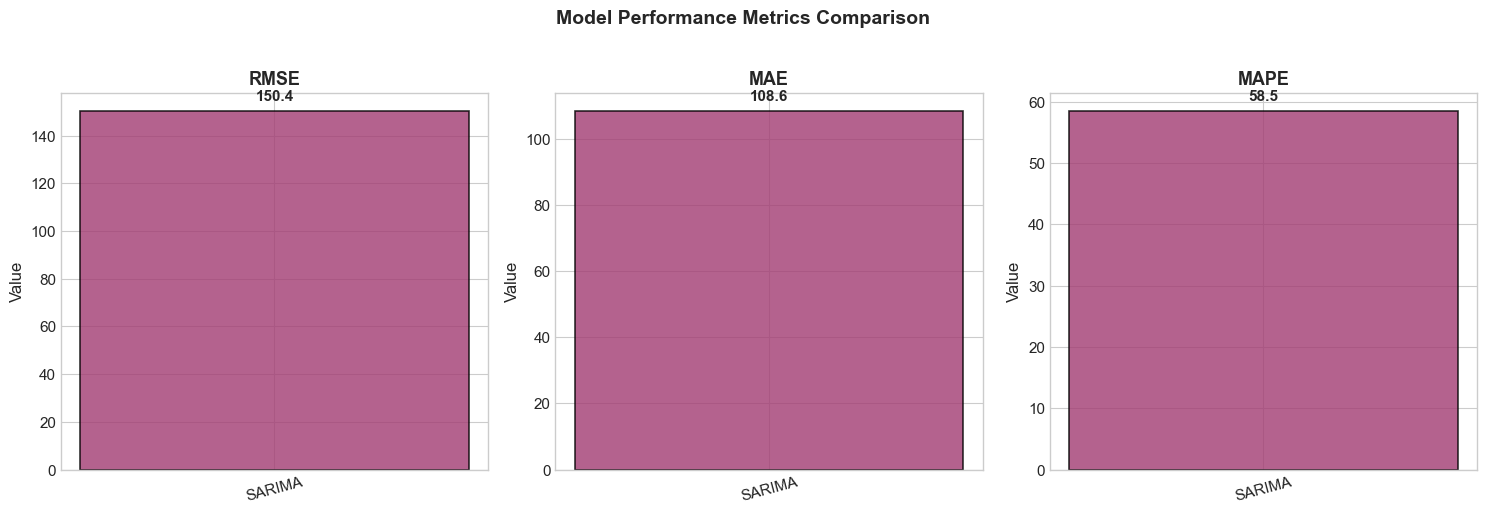


BEST MODEL: SARIMA (RMSE: 150.37)


In [45]:
# Model Performance Summary Table
from src.utils.metrics import evaluate_forecast

print("=" * 70)
print("MODEL PERFORMANCE COMPARISON (Test Set)")
print("=" * 70)

results = []

if prophet_pred is not None:
    prophet_metrics = evaluate_forecast(y_test.values, prophet_pred, name="Prophet")
    results.append(prophet_metrics)
    print(f"\nProphet:   RMSE={prophet_metrics['rmse']:.2f}  MAE={prophet_metrics['mae']:.2f}  MAPE={prophet_metrics['mape']:.1f}%")

if sarima_pred is not None:
    sarima_metrics = evaluate_forecast(y_test.values, sarima_pred, name="SARIMA")
    results.append(sarima_metrics)
    print(f"SARIMA:    RMSE={sarima_metrics['rmse']:.2f}  MAE={sarima_metrics['mae']:.2f}  MAPE={sarima_metrics['mape']:.1f}%")

if lgbm_pred is not None:
    lgbm_metrics = evaluate_forecast(y_test.values, lgbm_pred, name="LightGBM")
    results.append(lgbm_metrics)
    print(f"LightGBM:  RMSE={lgbm_metrics['rmse']:.2f}  MAE={lgbm_metrics['mae']:.2f}  MAPE={lgbm_metrics['mape']:.1f}%")

# Create comparison bar chart
if len(results) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    models = [r['model'] for r in results]
    colors = [COLORS['secondary'], COLORS['accent'], COLORS['success']][:len(results)]
    
    for idx, metric in enumerate(['rmse', 'mae', 'mape']):
        ax = axes[idx]
        values = [r[metric] for r in results]
        bars = ax.bar(models, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
        ax.set_title(metric.upper(), fontsize=13, fontweight='bold')
        ax.set_ylabel('Value')
        
        # Add value labels
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.02,
                    f'{val:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        ax.tick_params(axis='x', rotation=15)
    
    plt.suptitle('Model Performance Metrics Comparison', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(project_root / 'reports' / 'figures' / 'model_metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Determine best model
    best_model = min(results, key=lambda x: x['rmse'])
    print(f"\n{'='*70}")
    print(f"BEST MODEL: {best_model['model']} (RMSE: {best_model['rmse']:.2f})")
    print(f"{'='*70}")

## 7. Seasonality Decomposition

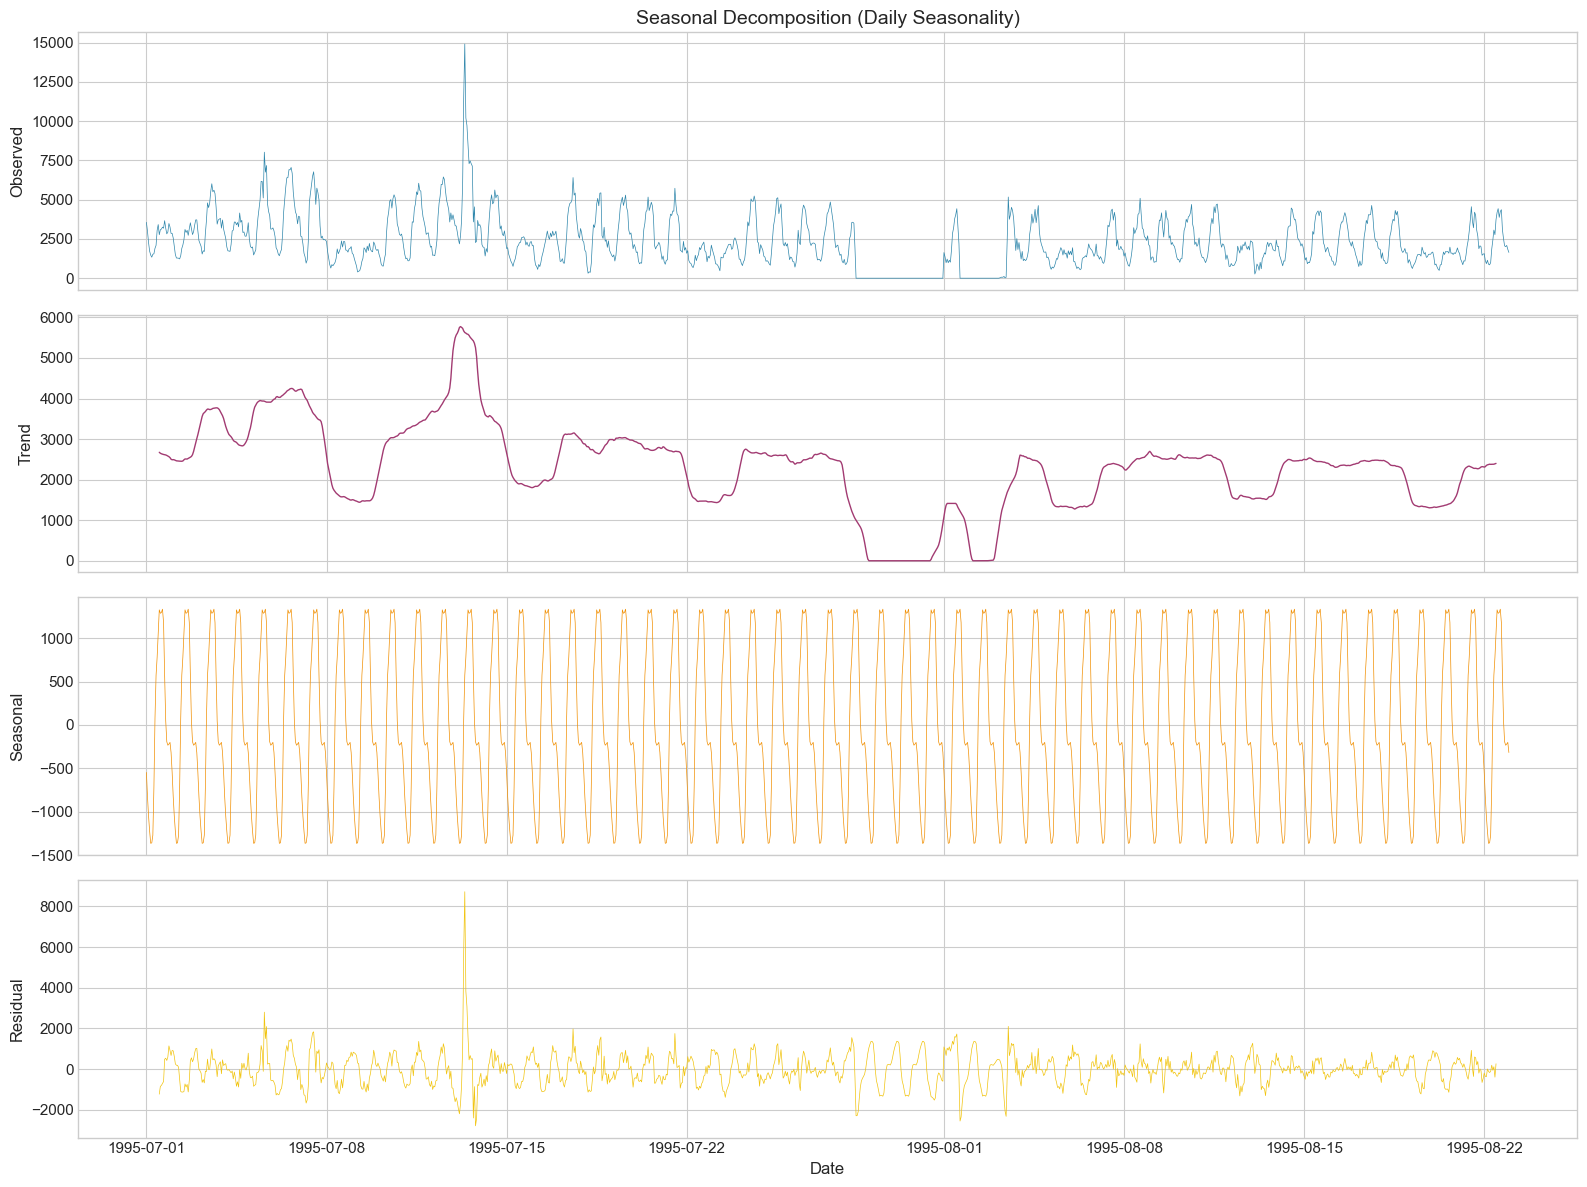

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Use hourly data for cleaner decomposition
# Note: pandas 2.x uses lowercase 'h' instead of 'H' for hourly frequency
df_hourly = df.set_index('timestamp').resample('h')['request_count'].sum()

# Decompose with daily seasonality (24 hours)
decomposition = seasonal_decompose(df_hourly, model='additive', period=24)

fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# Observed
ax = axes[0]
ax.plot(decomposition.observed, linewidth=0.5, color=COLORS['primary'])
ax.set_ylabel('Observed')
ax.set_title('Seasonal Decomposition (Daily Seasonality)')

# Trend
ax = axes[1]
ax.plot(decomposition.trend, linewidth=1, color=COLORS['secondary'])
ax.set_ylabel('Trend')

# Seasonal
ax = axes[2]
ax.plot(decomposition.seasonal, linewidth=0.5, color=COLORS['accent'])
ax.set_ylabel('Seasonal')

# Residual
ax = axes[3]
ax.plot(decomposition.resid, linewidth=0.5, color=COLORS['warning'])
ax.set_ylabel('Residual')
ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

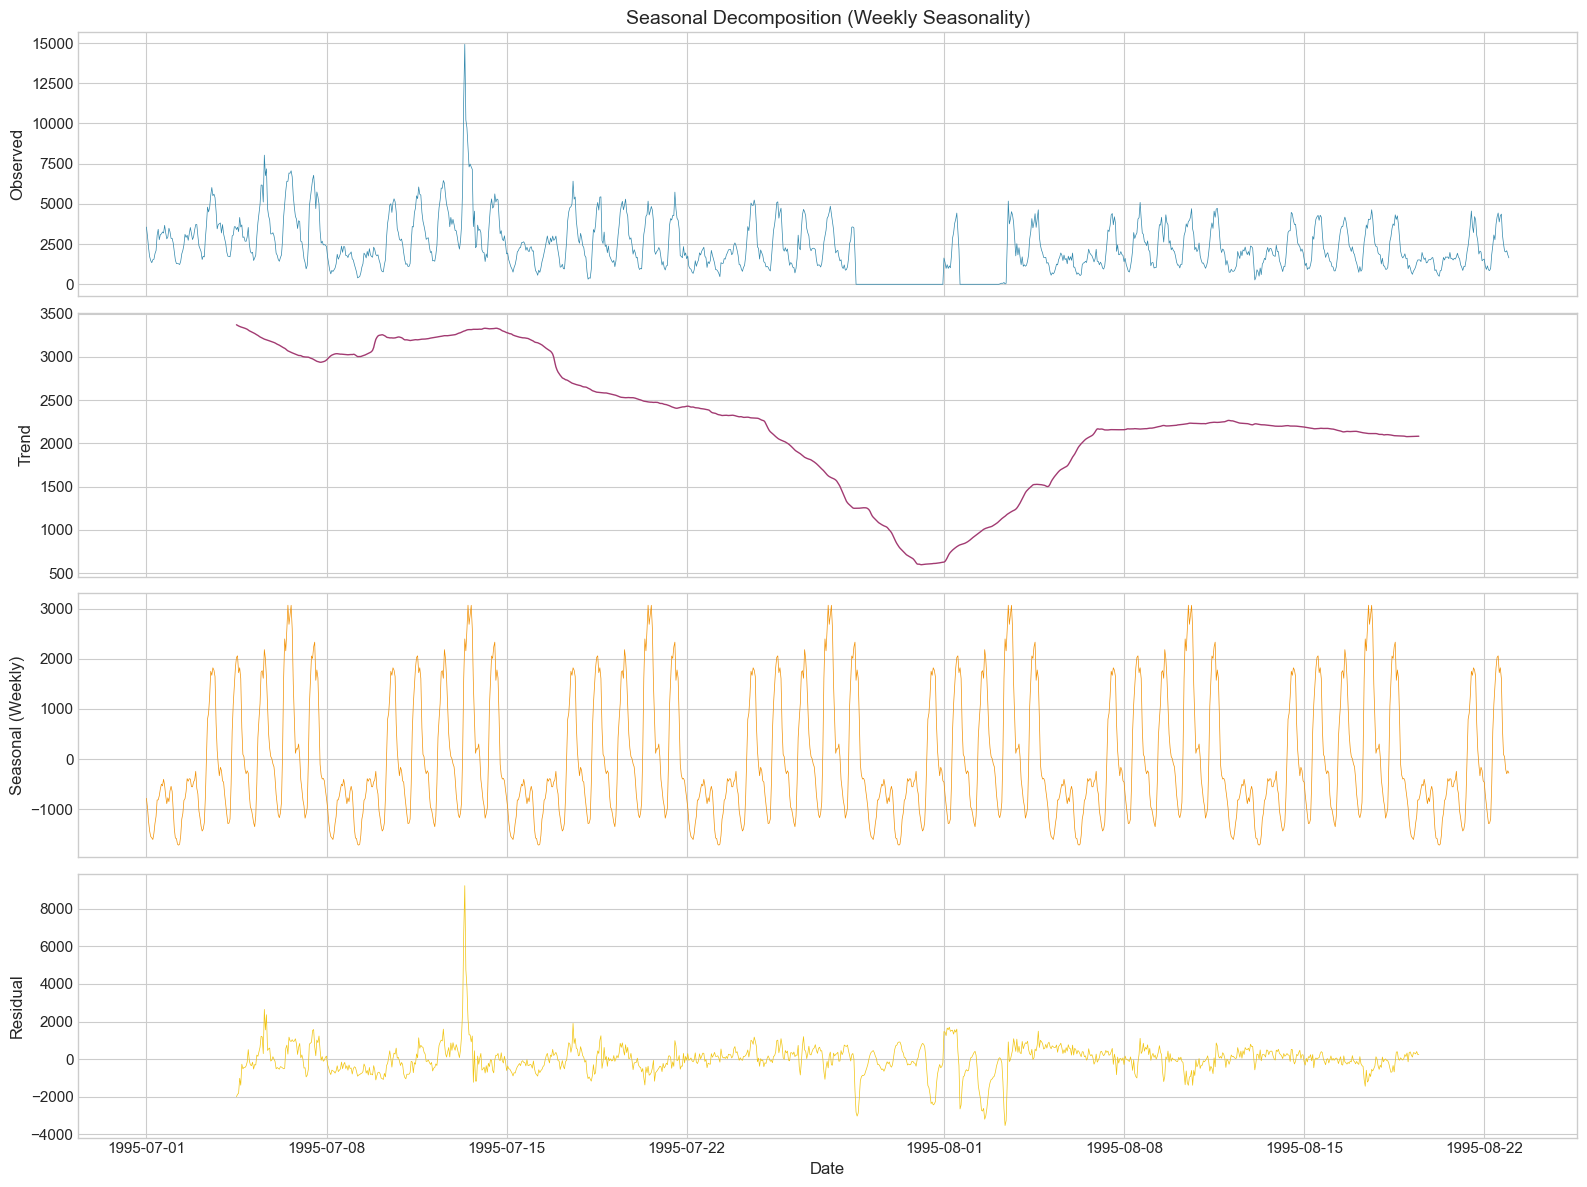

In [47]:
# Weekly seasonality decomposition
decomposition_weekly = seasonal_decompose(df_hourly, model='additive', period=24*7)  # 168 hours = 1 week

fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

axes[0].plot(decomposition_weekly.observed, linewidth=0.5, color=COLORS['primary'])
axes[0].set_ylabel('Observed')
axes[0].set_title('Seasonal Decomposition (Weekly Seasonality)')

axes[1].plot(decomposition_weekly.trend, linewidth=1, color=COLORS['secondary'])
axes[1].set_ylabel('Trend')

axes[2].plot(decomposition_weekly.seasonal, linewidth=0.5, color=COLORS['accent'])
axes[2].set_ylabel('Seasonal (Weekly)')

axes[3].plot(decomposition_weekly.resid, linewidth=0.5, color=COLORS['warning'])
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

## 8. ACF/PACF for ARIMA

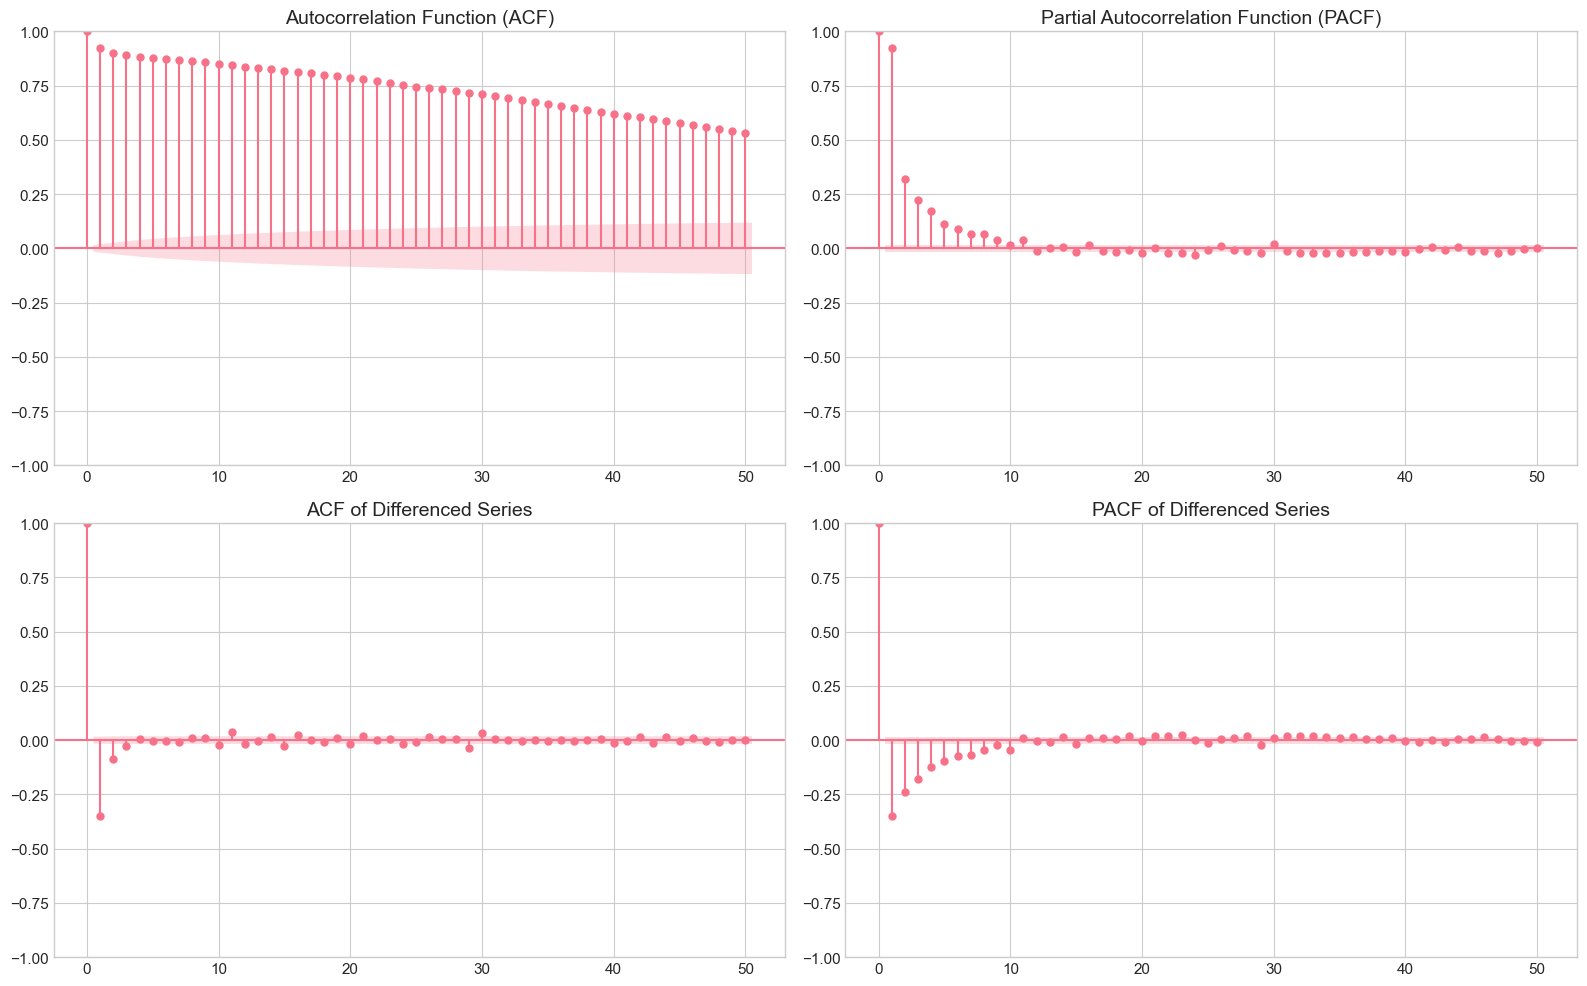


ARIMA Order Selection Hints:
- Strong autocorrelation suggests AR terms needed
- PACF cutoff suggests AR order (p)
- ACF cutoff suggests MA order (q)
- Seasonal patterns at lag 12 (1 hour) and 288 (1 day) for 5-min data


In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF
plot_acf(df['request_count'].dropna(), lags=50, ax=axes[0, 0])
axes[0, 0].set_title('Autocorrelation Function (ACF)')

# PACF
plot_pacf(df['request_count'].dropna(), lags=50, ax=axes[0, 1], method='ywm')
axes[0, 1].set_title('Partial Autocorrelation Function (PACF)')

# ACF of differenced series
diff_series = df['request_count'].diff().dropna()
plot_acf(diff_series, lags=50, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Differenced Series')

# PACF of differenced series
plot_pacf(diff_series, lags=50, ax=axes[1, 1], method='ywm')
axes[1, 1].set_title('PACF of Differenced Series')

plt.tight_layout()
plt.show()

print("\nARIMA Order Selection Hints:")
print("- Strong autocorrelation suggests AR terms needed")
print("- PACF cutoff suggests AR order (p)")
print("- ACF cutoff suggests MA order (q)")
print("- Seasonal patterns at lag 12 (1 hour) and 288 (1 day) for 5-min data")

## 9. Summary & Key Insights

In [49]:
print("=" * 60)
print("EDA KEY INSIGHTS")
print("=" * 60)

print("\n1. DATASET OVERVIEW")
print(f"   - Total training records: {len(df):,} (5-min windows)")
print(f"   - Total test records: {len(df_test):,}")
print(f"   - Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print(f"   - Features: {len(df.columns)}")

print("\n2. TRAFFIC PATTERNS")
print(f"   - Average: {df['request_count'].mean():.0f} requests/5min")
print(f"   - Peak: {df['request_count'].max():.0f} requests/5min")
print(f"   - Peak hours: 11:00-17:00 EST (US business hours)")
print(f"   - Weekend drop: {(1 - weekend_avg/weekday_avg)*100:.1f}%")

print("\n3. SEASONALITY")
print("   - Strong daily seasonality (24-hour cycle)")
print("   - Strong weekly seasonality (weekend effect)")
print("   - Business hours show significantly higher traffic")

print("\n4. ANOMALIES")
print(f"   - Total spikes detected: {len(spikes)}")
print(f"   - Notable spike: July 13, 1995 (special event?)")
print("   - Missing data: Aug 1-3 (hurricane)")

print("\n5. FEATURE IMPORTANCE (Top 5 correlations)")
for i, (feat, corr) in enumerate(correlations.head(5).items(), 1):
    print(f"   {i}. {feat}: {corr:.3f}")

print("\n6. RECOMMENDATIONS FOR MODELING")
print("   - Use lag features (especially lag_1, lag_12, lag_288)")
print("   - Include time features (hour, day_of_week, is_weekend)")
print("   - Consider SARIMA with seasonal order (12, 288)")
print("   - LightGBM with rolling features for best results")

EDA KEY INSIGHTS

1. DATASET OVERVIEW
   - Total training records: 15,264 (5-min windows)
   - Total test records: 2,592
   - Date range: 1995-07-01 to 1995-08-22
   - Features: 91

2. TRAFFIC PATTERNS
   - Average: 192 requests/5min
   - Peak: 1500 requests/5min
   - Peak hours: 11:00-17:00 EST (US business hours)
   - Weekend drop: 44.2%

3. SEASONALITY
   - Strong daily seasonality (24-hour cycle)
   - Strong weekly seasonality (weekend effect)
   - Business hours show significantly higher traffic

4. ANOMALIES
   - Total spikes detected: 10
   - Notable spike: July 13, 1995 (special event?)
   - Missing data: Aug 1-3 (hurricane)

5. FEATURE IMPORTANCE (Top 5 correlations)
   1. request_count_pct_of_max: 1.000
   2. request_count_ewm_mean_5: 0.972
   3. request_count_rolling_mean_3: 0.969
   4. unique_hosts: 0.965
   5. request_count_rolling_max_3: 0.959

6. RECOMMENDATIONS FOR MODELING
   - Use lag features (especially lag_1, lag_12, lag_288)
   - Include time features (hour, day_o

In [50]:
print("\nNotebook completed successfully!")


Notebook completed successfully!
